# Combined Census Total Pop, NY Times Mask and Covid-19 Data

#### This notebook contains code for gathering Census data tables, New York Times mask data, Covid Tracking Project data and converting them to dataframes. 
#### Please use caution when altering this code.

In [4]:
import pandas as pd
from census import Census #<-- Python wrapper for census API
import requests
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sts
import numpy as np
import plotly.graph_objects as go
import plotly.express as px


# Census API Key
from config import api_key

# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

In [5]:
tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)

##### The cell below gathering columns names from the Census Total Population table that only contain estimate and are int data types.
##### Those table names are added to a string variable and then pulled from the census data.
##### Dictionary key names are replaced withe more meaningful names.
##### Data is saved to a dataframe and exported as a csv file.

In [6]:
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B01003_TotalPop_df = pd.DataFrame(census_data)
census_B01003_TotalPop_df.to_csv("census_B01003_TotalPop.csv", encoding="utf-8", index=False )
census_B01003_TotalPop_df

Number of available variables: 4


,NAME,state,county,Estimate!!Total
0,"Washington County, Mississippi",28,151,47086.0
1,"Perry County, Mississippi",28,111,12028.0
2,"Choctaw County, Mississippi",28,019,8321.0
3,"Itawamba County, Mississippi",28,057,23480.0
4,"Carroll County, Mississippi",28,015,10129.0
...,...,...,...,...
3215,"Clayton County, Iowa",19,043,17672.0
3216,"Buena Vista County, Iowa",19,021,20260.0
3217,"Guthrie County, Iowa",19,077,10674.0
3218,"Humboldt County, Iowa",19,091,9566.0


### Census Total Population and New York Times Mask Data

In [7]:
census_B01003_TotalPop_df.dtypes

census_B01003_TotalPop_df['COUNTYFP'] = census_B01003_TotalPop_df['state'] + census_B01003_TotalPop_df['county']

census_TotalPop_sorted = census_B01003_TotalPop_df.sort_values(by=['COUNTYFP'])
census_TotalPop_sorted = census_TotalPop_sorted.reset_index(drop=True)

census_TotalPop_sorted['State Name'] = ''
census_TotalPop_sorted['County Name'] = ''


for index, row in census_TotalPop_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_TotalPop_sorted.loc[index, 'State Name']= clean_state
    census_TotalPop_sorted.loc[index, 'County Name']= name_list[0]
    
census_TotalPop_sorted.head()

,NAME,state,county,Estimate!!Total,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",01,001,55200.0,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",01,003,208107.0,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",01,005,25782.0,01005,Alabama,Barbour County
3,"Bibb County, Alabama",01,007,22527.0,01007,Alabama,Bibb County
4,"Blount County, Alabama",01,009,57645.0,01009,Alabama,Blount County


In [8]:
infile = os.path.join("..", "NY_Times_Data", "mask-use-by-county.csv" )
nytimes_mask_data = pd.read_csv(infile)
# nytimes_mask_data.dtypes
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].astype(str)
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].str.zfill(5)
nytimes_mask_data.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459


In [9]:
nytimesmask_census = pd.merge(nytimes_mask_data, census_TotalPop_sorted, on="COUNTYFP", how="left")
nytimesmask_census.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,NAME,state,county,Estimate!!Total,State Name,County Name
0,01001,0.053,0.074,0.134,0.295,0.444,"Autauga County, Alabama",01,001,55200.0,Alabama,Autauga County
1,01003,0.083,0.059,0.098,0.323,0.436,"Baldwin County, Alabama",01,003,208107.0,Alabama,Baldwin County
2,01005,0.067,0.121,0.120,0.201,0.491,"Barbour County, Alabama",01,005,25782.0,Alabama,Barbour County
3,01007,0.020,0.034,0.096,0.278,0.572,"Bibb County, Alabama",01,007,22527.0,Alabama,Bibb County
4,01009,0.053,0.114,0.180,0.194,0.459,"Blount County, Alabama",01,009,57645.0,Alabama,Blount County


In [10]:
nytimesmaskcensus_grouped = nytimesmask_census.groupby(['State Name', 'state'])
# nytimesmaskcensus_grouped.count()
nytimesmaskcensus_mean = round(nytimesmaskcensus_grouped.mean(), 3)
nytimesmaskcensus_sum = nytimesmaskcensus_grouped.sum()
nytimesmaskcensus_sum
nytimesmaskcensus_stats = nytimesmaskcensus_mean.drop(columns='Estimate!!Total')

nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'] = nytimesmaskcensus_sum['Estimate!!Total']
# nytimesmaskcensus_stats['NEVER - POP'] = round(nytimesmaskcensus_stats['NEVER'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['RARELY - POP'] = round(nytimesmaskcensus_stats['RARELY'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0)
# nytimesmaskcensus_stats['SOMETIMES - POP'] = round(nytimesmaskcensus_stats['SOMETIMES'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['FREQUENTLY - POP'] = round(nytimesmaskcensus_stats['FREQUENTLY'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
# nytimesmaskcensus_stats['ALWAYS - POP'] = round(nytimesmaskcensus_stats['ALWAYS'] * nytimesmaskcensus_stats['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats = nytimesmaskcensus_stats.reset_index()
nytimesmaskcensus_stats.head()


,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE)
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0


#### Covid-19 Data

In [11]:
# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"

covid_json = requests.get(url).json()

In [12]:
states= []
fips = []
deaths= []
covid_positives = []
dates = []

indices = list(range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    covid_positives.append(covid_json[i]['positive'])

In [13]:
AllStates_dict = {
    "States": states,
    "FIPS": fips,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict )
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Deaths
0,AK,02,20200920,7767,45
1,AL,01,20200920,144962,2437
2,AR,05,20200920,75723,1181
3,AS,60,20200920,0,0
4,AZ,04,20200920,214018,5476


In [14]:
mask_covid_data = pd.merge(nytimesmaskcensus_stats, AllStates_df, how="outer", left_on='state', right_on='FIPS')

mask_covid_data
mask_covid_data_clean = mask_covid_data.dropna(axis=0, how='any')
mask_covid_data_clean.head()

,State Name,state,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,TOTAL POP (ESTIMATE),States,FIPS,Date,Covid Positive,Deaths
0,Alabama,01,0.082,0.081,0.147,0.215,0.475,4864680.0,AL,01,20200920,144962,2437
1,Alaska,02,0.055,0.063,0.090,0.333,0.459,738516.0,AK,02,20200920,7767,45
2,Arizona,04,0.050,0.053,0.095,0.147,0.655,6946685.0,AZ,04,20200920,214018,5476
3,Arkansas,05,0.091,0.087,0.138,0.221,0.463,2990671.0,AR,05,20200920,75723,1181
4,California,06,0.032,0.031,0.064,0.159,0.715,39148760.0,CA,06,20200920,778400,14987


The correlation coefficient (r) is 0.2
The p-value is 0.15143615559180257


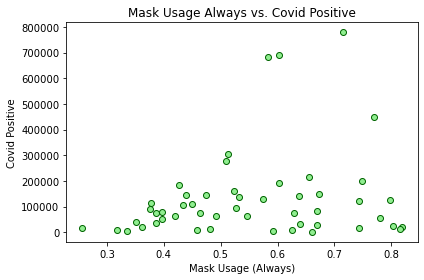

In [15]:
plt.scatter(x=mask_covid_data_clean['ALWAYS'], y=mask_covid_data_clean['Covid Positive'], marker="o", facecolors="lightgreen", edgecolors="darkgreen")

plt.style.use("dark_background")
plt.title("Mask Usage Always vs. Covid Positive")
plt.ylabel("Covid Positive")
plt.xlabel("Mask Usage (Always)")

plt.tight_layout()
plt.savefig('mask_always.png', transparent=True)


correlation = sts.pearsonr(mask_covid_data_clean['ALWAYS'],mask_covid_data_clean['Covid Positive'] )
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

The correlation coefficient (r) is -0.2
The p-value is 0.15150945774055574


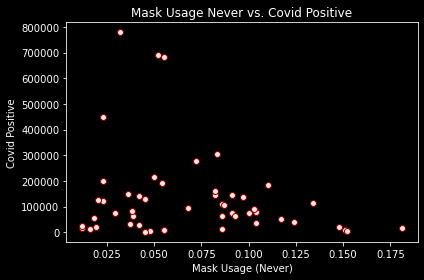

In [16]:
plt.scatter(x=mask_covid_data_clean['NEVER'], y=mask_covid_data_clean['Covid Positive'], marker="o", facecolors="mistyrose", edgecolors="darkred")

plt.style.use("dark_background")
plt.title("Mask Usage Never vs. Covid Positive")
plt.ylabel("Covid Positive")
plt.xlabel("Mask Usage (Never)")
plt.tight_layout()
plt.savefig('mask_never.png', transparent=True)


correlation = sts.pearsonr(mask_covid_data_clean['NEVER'],mask_covid_data_clean['Covid Positive'] )
print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The p-value is {correlation[1]}")

#### Mask Use Frequency versus Percentage of Survey Responders

In [32]:
def getquartilesIQR(col):
    quantiles = mask_covid_data_clean[col].quantile([0.25, 0.75])
    IQR = quantiles[0.75] - quantiles[0.25]
    lower_bound = round(quantiles[0.25] - (1.5*IQR), 2) 
    upper_bound = round(quantiles[0.75] + (1.5*IQR), 2)
    print(col)
    print(f"First and Third Quartile are {quantiles[0.25]} and {quantiles[0.75]}")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    outliers = mask_covid_data_clean.loc[(mask_covid_data_clean[col] < lower_bound) | (mask_covid_data_clean[col] 
                > upper_bound)]
    print("Outliers States:", outliers["State Name"].values.tolist())
    
getquartilesIQR("ALWAYS")
getquartilesIQR("SOMETIMES")
getquartilesIQR("FREQUENTLY")
getquartilesIQR("RARELY")
getquartilesIQR("NEVER")
    


ALWAYS
First and Third Quartile are 0.4305 and 0.665
Values below 0.08 could be outliers.
Values above 1.02 could be outliers.
Outliers States: []
SOMETIMES
First and Third Quartile are 0.0765 and 0.145
Values below -0.03 could be outliers.
Values above 0.25 could be outliers.
Outliers States: []
FREQUENTLY
First and Third Quartile are 0.1675 and 0.219
Values below 0.09 could be outliers.
Values above 0.3 could be outliers.
Outliers States: ['Alaska']
RARELY
First and Third Quartile are 0.044 and 0.1015
Values below -0.04 could be outliers.
Values above 0.19 could be outliers.
Outliers States: []
NEVER
First and Third Quartile are 0.0375 and 0.095
Values below -0.05 could be outliers.
Values above 0.18 could be outliers.
Outliers States: ['North Dakota']


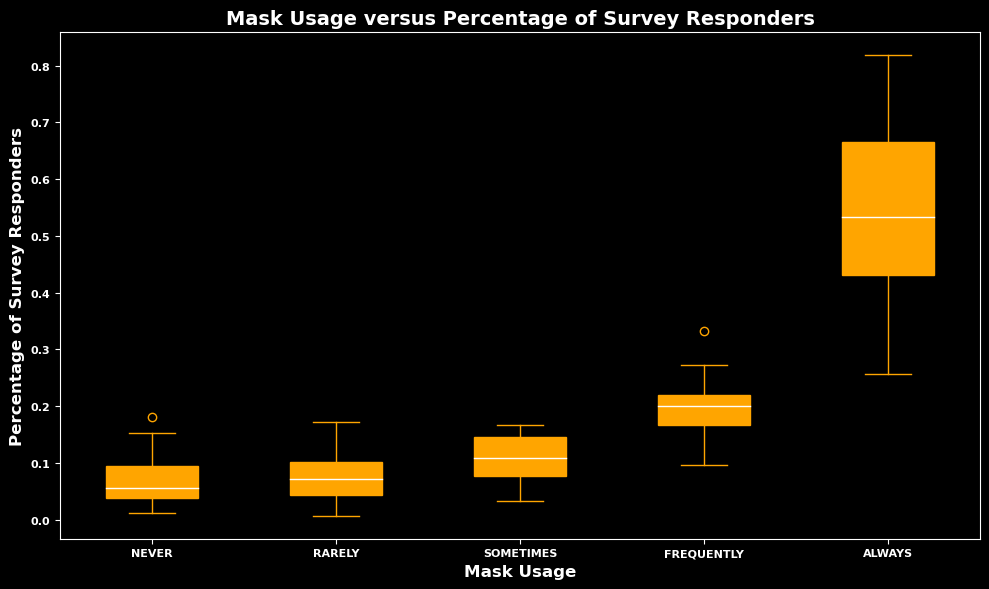

In [19]:
# Set color to orange
c = 'orange'
# Create dictionary of keyword aruments to pass to plt.boxplot
orange_dict =  {'patch_artist': True,
             'boxprops': dict(color=c, facecolor=c),
             'capprops': dict(color=c),
             'flierprops': dict(color=c, markeredgecolor=c),
             'medianprops': dict(color="white"),
             'whiskerprops': dict(color=c)}

plt.style.use('dark_background')
cols = ["NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]
values = [mask_covid_data_clean[c] for c in cols]
plt.figure(figsize=(10,6))
plt.boxplot(values, whis=1.47, **orange_dict)
plt.xticks(np.arange(1,len(cols)+1), cols, fontsize=8, weight='bold')
plt.yticks(fontsize=8, weight='bold')
plt.ylabel("Percentage of Survey Responders", fontsize=12, weight='bold')
plt.xlabel("Mask Usage", fontsize=12, weight='bold')
plt.title("Mask Usage versus Percentage of Survey Responders", fontsize=14, weight='bold')
plt.tight_layout()

outfile = os.path.join("Output", 'Covid19_Mask_Data_Boxplots_Transparent.png')
plt.savefig(outfile, transparent=True)

In [31]:
color="white"

fig = px.choropleth(mask_covid_data_clean, locations="States", locationmode="USA-states", color= "ALWAYS", scope="usa", 
                    title="NY Times Mask Usage Poll - 'ALWAYS'")

fig.update_layout(geo=dict(bgcolor= 'rgba(0,0,0,0)'))
fig.update_layout({
                    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                    'paper_bgcolor': 'rgba(0, 0, 0, 0)',

                    })
fig.update_layout( font_color=color,title_font_color=color,legend_title_font_color=color)
fig.show()

outfile = os.path.join("Output", 'Covid19_Mask_Always_Transparent.png')
fig.write_image(outfile)
